In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from cp_detection.NeuralODE import GeneralModeDataset, LightningTrainer, LoadModel

In [3]:
class SyntheticGeneralModeAFM():
    
    def __init__(self, ode_params, F, t):
        self.ode_params = dict(ode_params)
        self.F = F
        
        self.d = 0.0
        self.x0 = np.array([self.ode_params['A0'], self.ode_params['A0']])
        
        self.t = np.array(t)
        
    def ODE(self, t, x):
        Q = self.ode_params['Q']
        A0 = self.ode_params['A0']
        Om = self.ode_params['Om']
        k = self.ode_params['k']
        
        # x = [y, z] where y = dz/dt
        y = x[0]
        z = x[1]
        
        return np.array([-y/Q-(z-self.d)+A0*np.cos(Om*t)/Q+F(z)/k, y])
    
    def ComputeSolution(self, noise_scale = 0.3):
        sol = solve_ivp(self.ODE, (self.t[0], self.t[-1]), self.x0, t_eval = self.t)
        z = sol.y[1,:] + np.random.normal(scale = noise_scale, size = sol.y[1,:].shape)
        
        return z
    
    def CreateDataset(self, d_list):
        d_list = np.array(d_list)
        z_list = []
        
        for d in d_list:
            self.d = d
            z_list.append(self.ComputeSolution())
        
        dataset = GeneralModeDataset(self.t, d_list, self.x0, z_list, self.ode_params)
        
        return dataset

In [9]:
ode_params = {'Q':12000, 'A0':0.5, 'Om':1., 'k':1000}
t = np.linspace(0, 50, 1000)

# Interaction force
def F(z):
    return -5/z**2

SyntheticAFM = SyntheticGeneralModeAFM(ode_params, F, t)
train_dataset = SyntheticAFM.CreateDataset(np.linspace(3.0, 10.0, 40))

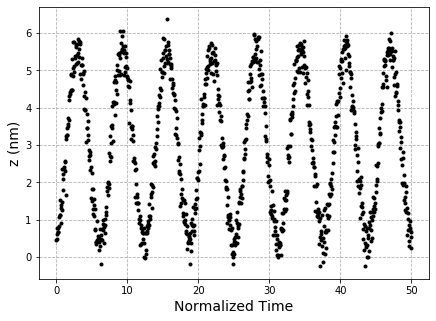

In [4]:
fig, ax = train_dataset.PlotData(0)

In [5]:
import torch
if torch.cuda.is_available:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [6]:
from argparse import Namespace
hparams = Namespace(**{'train_dataset': train_dataset, 'hidden_nodes': [10, 10], 'lr': 0.02, 'batch_size': 40, 'solver': 'dopri5'})
model = LightningTrainer(hparams)

In [7]:
import os
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(filepath = './checkpoints', save_best_only = True, verbose = True, monitor = 'loss', mode = 'min', prefix = '')
trainer = Trainer(gpus = 1, early_stop_callback = None, checkpoint_callback = checkpoint_callback, show_progress_bar = True, max_nb_epochs=10000)

In [ ]:
trainer.fit(model)

Epoch 1023:   0%|          | 0/1 [00:00<00:49, 49.52s/batch, batch_nb=0, gpu=0, loss=85.029, v_nb=7]

## Load trained model, evaluate results

In [4]:
checkpoint_path = './hall_of_fame/20200204/_ckpt_epoch_811.ckpt'
model = LoadModel(checkpoint_path)

In [6]:
d = np.linspace(3.0, 10.0, 40)
model.cuda()
F_pred = model.predict_force(d)

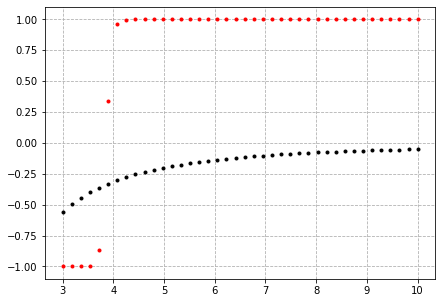

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
ax.plot(d, F_pred, '.r', label = 'NN prediction')
ax.plot(d, F(d), '.k', label = 'True Force')
ax.grid(ls = '--')

In [3]:
sol = solve_ivp(ODE, (0, 50), x0, t_eval = np.linspace(0, 50, 1000))
data = sol.y[1,:] + np.random.normal(scale = 0.3, size = sol.y[1,:].shape)

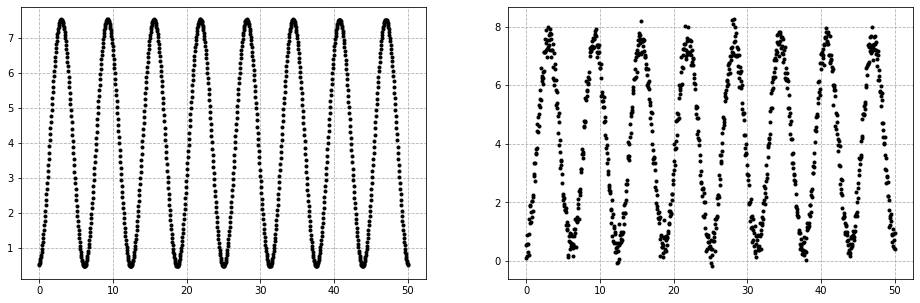

In [4]:
fig, axes = plt.subplots(1, 2, figsize = (16, 5))
axes[0].plot(sol.t, sol.y[1,:], '.k')
axes[1].plot(sol.t, data, '.k')
for ax in axes:
    ax.grid(ls = '--')

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchdiffeq import odeint_adjoint as odeint
from torchviz import make_dot, make_dot_from_trace

In [13]:
class Fint(nn.Module):
    
    def __init__(self, ndense):
        super(Fint, self).__init__()
        self.elu = nn.ELU()
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(1, ndense)
        self.fc2 = nn.Linear(ndense, ndense)
        self.fc3 = nn.Linear(ndense, 1)
        
    def forward(self, x):
        
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        out = self.tanh(out)
        
        return out
    
class NN_ODE(nn.Module):
    
    def __init__(self, ndense, Q, A0, Om, k, d):
        super(NN_ODE, self).__init__()
        self.F = Fint(ndense)
        self.Q = Q
        self.A0 = A0
        self.Om = Om
        self.k = k
        self.d = d
        self.nfe = 0
        self.B = torch.tensor([[-1./self.Q, -1.], [1., 0.]], device = device)
        self.C = torch.tensor([1.,0.], device = device)
        
    def forward(self, t, x):
        self.nfe+=1
        F = self.F(x[1].unsqueeze(-1))
        #ode = torch.matmul(self.B, x) + (self.d + self.A0*torch.cos(self.Om*t)/self.Q + F/self.k) * self.C
        ode = torch.matmul(self.B, x) + (self.d + self.A0*torch.cos(self.Om*t)/self.Q + F) * self.C
        # Currently, force term is self.k times larger
        return ode

    

In [14]:
nnode = NN_ODE(4, **params)
nnode.float()
nnode.cuda()
nnode.parameters

NameError: name 'params' is not defined

In [9]:
optimizer = torch.optim.Adam(nnode.parameters(), lr = 0.01)
loss_function = nn.MSELoss()

x0_tensor = torch.from_numpy(x0).cuda(non_blocking = True).float()
t_samp = torch.from_numpy(sol.t).cuda(non_blocking = True).float()
data = torch.from_numpy(data).cuda(non_blocking = True).float()

torch.Size([501])


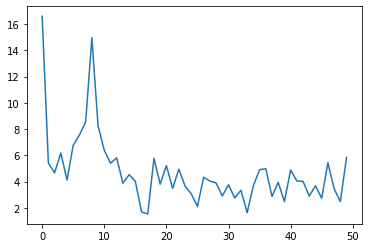

In [10]:
data_fft = torch.rfft(data, 1, onesided = True)
data_amp = torch.sum(data_fft**2, dim = -1)
data_logamp = torch.log1p(data_amp)
print(data_logamp.size())

logamp_array = data_logamp.cpu().detach().numpy()
plt.plot(logamp_array[0:50])

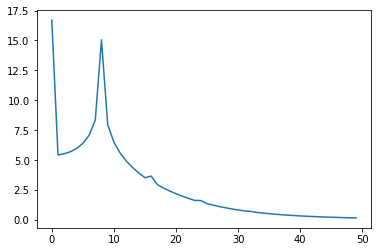

In [11]:
x_pred = odeint(nnode, x0_tensor, t_samp)
z_pred = x_pred[:,1]
z_fft = torch.rfft(z_pred, 1)
z_amp = torch.sum(z_fft**2, dim = -1)
z_logamp = torch.log1p(z_amp)
z_logamp.size()
loss = loss_function(z_logamp, data_logamp)


zlogamp_array = z_logamp.cpu().detach().numpy()
plt.plot(zlogamp_array[0:50])

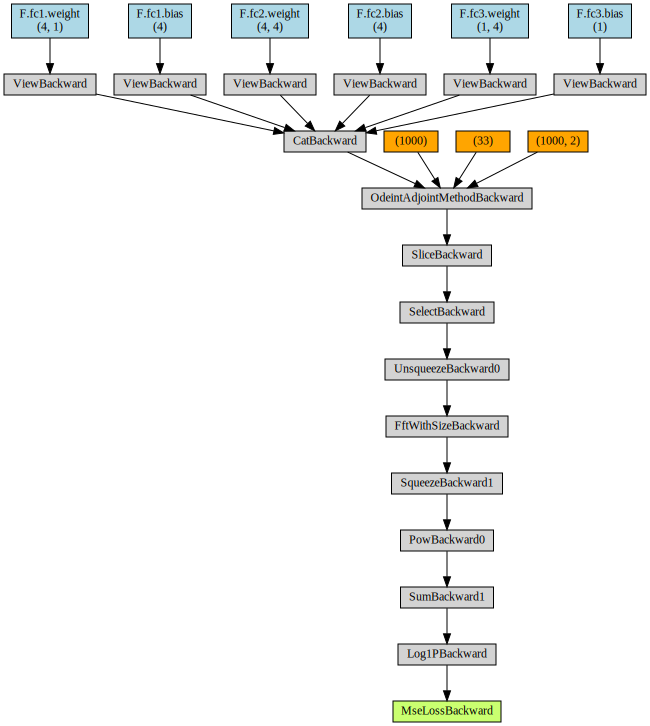

In [12]:
make_dot(loss, params=dict(nnode.named_parameters()))

In [40]:
N_epochs = 500
history = np.zeros((N_epochs, 1))
for epoch in range(N_epochs):
    
    # zero the parameter gradients
    optimizer.zero_grad()
    running_loss = 0.0
    
    solut = odeint(nnode, x0_tensor, t_samp, method = 'adams')
    z_pred = solut[:,1]
    
    z_fft = torch.rfft(z_pred, 1)
    z_amp = torch.sum(z_fft**2, dim = -1)
    #z_fft = torch.rfft(z_pred, 1)
    z_logamp = torch.log1p(z_amp)
    #z_logamp.size()
    loss = loss_function(z_logamp, data_logamp)
    #loss = loss_function(z_amp, data_amp)
    #loss = loss_function(z_pred, data)
    loss.backward()
    optimizer.step()
    
    # print statistics
    running_loss += loss.item()
    print('[%d] loss: %.12e' %(epoch + 1, running_loss))
    history[epoch] = running_loss
    
print('Training Finished')

[1] loss: 4.048020362854e+00
[2] loss: 4.047791481018e+00
[3] loss: 4.047648906708e+00
[4] loss: 4.047481060028e+00
[5] loss: 4.047161579132e+00
[6] loss: 4.047134399414e+00
[7] loss: 4.046728134155e+00
[8] loss: 4.046549797058e+00
[9] loss: 4.046325206757e+00
[10] loss: 4.047521591187e+00
[11] loss: 4.046006679535e+00
[12] loss: 4.046000003815e+00
[13] loss: 4.045728683472e+00
[14] loss: 4.045413970947e+00
[15] loss: 4.045269489288e+00
[16] loss: 4.045350551605e+00
[17] loss: 4.045305728912e+00
[18] loss: 4.045450687408e+00
[19] loss: 4.045453071594e+00
[20] loss: 4.045050144196e+00
[21] loss: 4.044756412506e+00
[22] loss: 4.044886112213e+00
[23] loss: 4.044848918915e+00
[24] loss: 4.044708251953e+00
[25] loss: 4.044720649719e+00
[26] loss: 4.044543266296e+00
[27] loss: 4.044691085815e+00
[28] loss: 4.044680595398e+00
[29] loss: 4.044635295868e+00
[30] loss: 4.044670581818e+00
[31] loss: 4.044861793518e+00
[32] loss: 4.044572830200e+00
[33] loss: 4.044628143311e+00
[34] loss: 4.044600

[269] loss: 4.044596672058e+00
[270] loss: 4.044489383698e+00
[271] loss: 4.044559001923e+00
[272] loss: 4.044847965240e+00
[273] loss: 4.044569015503e+00
[274] loss: 4.044867038727e+00
[275] loss: 4.044818401337e+00
[276] loss: 4.044636249542e+00
[277] loss: 4.044708251953e+00
[278] loss: 4.044350147247e+00
[279] loss: 4.044549942017e+00
[280] loss: 4.044502735138e+00
[281] loss: 4.044807910919e+00
[282] loss: 4.044570446014e+00
[283] loss: 4.044586181641e+00
[284] loss: 4.044519424438e+00
[285] loss: 4.044499874115e+00
[286] loss: 4.045160770416e+00
[287] loss: 4.044820308685e+00
[288] loss: 4.044409275055e+00
[289] loss: 4.044416427612e+00
[290] loss: 4.044360160828e+00
[291] loss: 4.044494628906e+00
[292] loss: 4.045131206512e+00
[293] loss: 4.044528961182e+00
[294] loss: 4.044828891754e+00
[295] loss: 4.044580459595e+00
[296] loss: 4.044479846954e+00
[297] loss: 4.044279098511e+00
[298] loss: 4.044578075409e+00
[299] loss: 4.044566631317e+00
[300] loss: 4.044611454010e+00
[301] lo

Text(0.5, 1.0, 'Learning Curve')

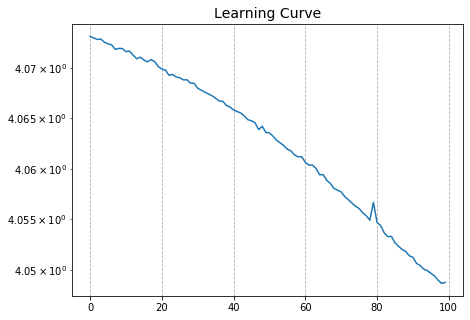

In [35]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
ax.plot(history)
ax.set_yscale('log')
ax.grid(ls = '--')
ax.set_title('Learning Curve', fontsize = 14)

In [36]:
sol = odeint(nnode, x0_tensor, t_samp)
z_final = sol[:,1].cpu().detach().numpy()

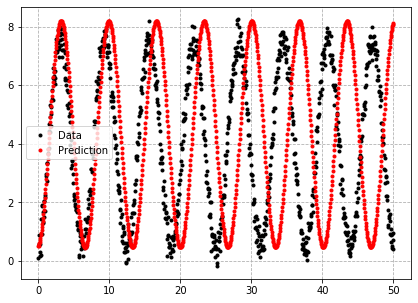

In [37]:
t = t_samp.cpu().detach().numpy()
z_true = data.cpu().detach().numpy()
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
ax.plot(t, z_true, '.k', label = 'Data')
ax.plot(t, z_final, '.r', label = 'Prediction')
ax.legend()
ax.grid(ls = '--')

In [38]:
d_array = np.linspace(1, 8, 1000)
d_tensor = torch.from_numpy(d_array).cuda(non_blocking = True).float()
F_true = F(d_array)
F_pred = np.zeros(d_array.shape)
for i in range(len(F_pred)):
    F_pred[i] = nnode.F(d_tensor[i].unsqueeze(-1)).cpu().detach().numpy()

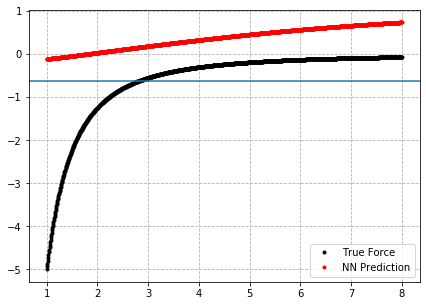

In [39]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
ax.plot(d_array, F_true, '.k', label = 'True Force')
ax.plot(d_array, F_pred, '.r', label = 'NN Prediction')
ax.axhline(F_true.mean())
ax.legend()
ax.grid(ls = '--')

In [22]:
F_pred

array([-0.99629951, -0.99634975, -0.99639934, -0.99644816, -0.99649632,
       -0.99654371, -0.9965905 , -0.99663657, -0.99668199, -0.99672675,
       -0.99677086, -0.99681437, -0.99685723, -0.99689949, -0.99694115,
       -0.99698222, -0.99702269, -0.99706262, -0.99710196, -0.99714071,
       -0.99717897, -0.99721664, -0.99725378, -0.99729043, -0.99732655,
       -0.99736214, -0.99739724, -0.99743187, -0.99746603, -0.99749964,
       -0.99753284, -0.99756557, -0.99759781, -0.99762958, -0.99766093,
       -0.99769187, -0.99772239, -0.99775243, -0.99778211, -0.99781132,
       -0.99784017, -0.9978686 , -0.99789667, -0.99792433, -0.99795157,
       -0.99797851, -0.99800503, -0.9980312 , -0.99805695, -0.9980824 ,
       -0.99810749, -0.99813229, -0.99815667, -0.99818075, -0.99820453,
       -0.99822795, -0.99825102, -0.99827385, -0.99829632, -0.99831849,
       -0.99834037, -0.99836195, -0.99838322, -0.9984042 , -0.99842489,
       -0.99844533, -0.99846548, -0.99848539, -0.99850494, -0.99